<div id="c-s-hlist">
    <ul>
        <li><a href="#intro">Intro</a></li>
        <li><a href="#import-data">Import Data</a></li>
        <li><a href="#pre-processing">Pre-Processing of Data</a></li>
        <li><a href="#feature-selection">Feature Selection</a></li>
        <li><a href="#generalize-data">Generalize Data</a></li>
        <li><a href="#model">Model and Training</a></li>
        <li><a href="#eval">Model Evaluation</a></li>
        <li><a href="#closing-words">Closing words</a></li>
    </ul>
</div>

<h2 id='intro'> Intro </h2>

&emsp; From <span class="post-content-link"><a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data" target="_blank">House Prices - Advanced Regression Techniques</a></span> this dataset is target to predict a house price and we can specific this is regression problem. And will use Artificial Neuron Network (ANNs) to training and predicting. This challenge will use same data pre-processing step as challenge before that is <a href='{{ site.baseurl }}{{ "/2024-10-30-house_price_prediction" | post_url }}'>House Price Prediction</a>,
</b> but need not to handling the outlier for try to capturing a complex pattern with ANNs.

<h2 id='import-data'>Import data</h2>

In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For training set
house_price_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
house_price = pd.read_csv(house_price_path, index_col='Id')
print(house_price.shape)

# For test set
house_price_test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
house_price_test = pd.read_csv(house_price_test_path, index_col='Id')
print(house_price_test.shape)

(1460, 80)
(1459, 79)


In [ ]:
train_raw = house_price.drop(columns=['SalePrice']).copy()
test_raw = house_price_test.copy()
target = house_price['SalePrice'].copy()

<h2 id='pre-processing'>Pre-Processing of Data</h2>

In [ ]:
# Check feature data type
train_raw.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [ ]:
missing_val_features = train_raw.isnull().sum()
missing_features = missing_val_features[missing_val_features > 0]
missing_features = missing_features.to_dict()
missing_features

{'LotFrontage': 259,
 'Alley': 1369,
 'MasVnrType': 872,
 'MasVnrArea': 8,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Electrical': 1,
 'FireplaceQu': 690,
 'GarageType': 81,
 'GarageYrBlt': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PoolQC': 1453,
 'Fence': 1179,
 'MiscFeature': 1406}

- ### Feature analysis

- #### Numeric categorical feature

In [ ]:
numeric_features = train_raw.select_dtypes(include=['float64', 'int64']).columns

# Define a threshold for low cardinality
threshold = 20  # Adjust based on your dataset
# Identify potential categorical features based on low cardinality
# cardinality = train_raw[col].nunique()  # nunique() is find a unique value is not include Nan
potential_categorical_features = [col for col in numeric_features if train_raw[col].nunique() < threshold]
print("Potential categorical features based on cardinality:")
print(potential_categorical_features)

# Calculate the correlation matrix
correlation_matrix = train_raw[numeric_features].corr().abs()
# Set threshold
threshold = 0.2
# Find features that have a correlation lower than the threshold with any other feature
low_corr_features = correlation_matrix.columns[(correlation_matrix < threshold).any()].to_list()
print("\nFeatures likely to be categorical based on correlation threshold:\n", low_corr_features)

# Combined them
numeric_category_features = list(set(potential_categorical_features).union(low_corr_features))

# Cross check with domain knowleadge are found tha not is a categorical, so remove them.
features_to_remove = {
            'TotalBsmtSF', '1stFlrSF', 'OpenPorchSF', 'YrSold', 'BsmtUnfSF', 'YearRemodAdd', 'YearBuilt',
            'LotFrontage', 'BsmtFinSF2','LowQualFinSF', 'GarageArea', 'EnclosedPorch', '3SsnPorch',
            '2ndFlrSF', 'WoodDeckSF', '2ndFlrSF', 'ScreenPorch', 'MiscVal', 'BsmtFinSF1', 'GrLivArea',
            'EnclosedPorch', 'LotArea', 'MasVnrArea', 'PoolArea', 'GarageYrBlt', 'Fireplaces',
            'BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageCars'
}
numeric_category_features = [feature for feature in numeric_category_features if feature not in features_to_remove]
print("\nNumeric categorical features:",numeric_category_features)

Potential categorical features based on cardinality:
['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold']

Features likely to be categorical based on correlation threshold:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Numeric categorical features: ['KitchenAbvGr', 'BedroomAbvGr', 'OverallCond', 'MSSubClass', 'TotRmsAbvGrd', 'MoSold', 'OverallQual']


- #### Numeric feature

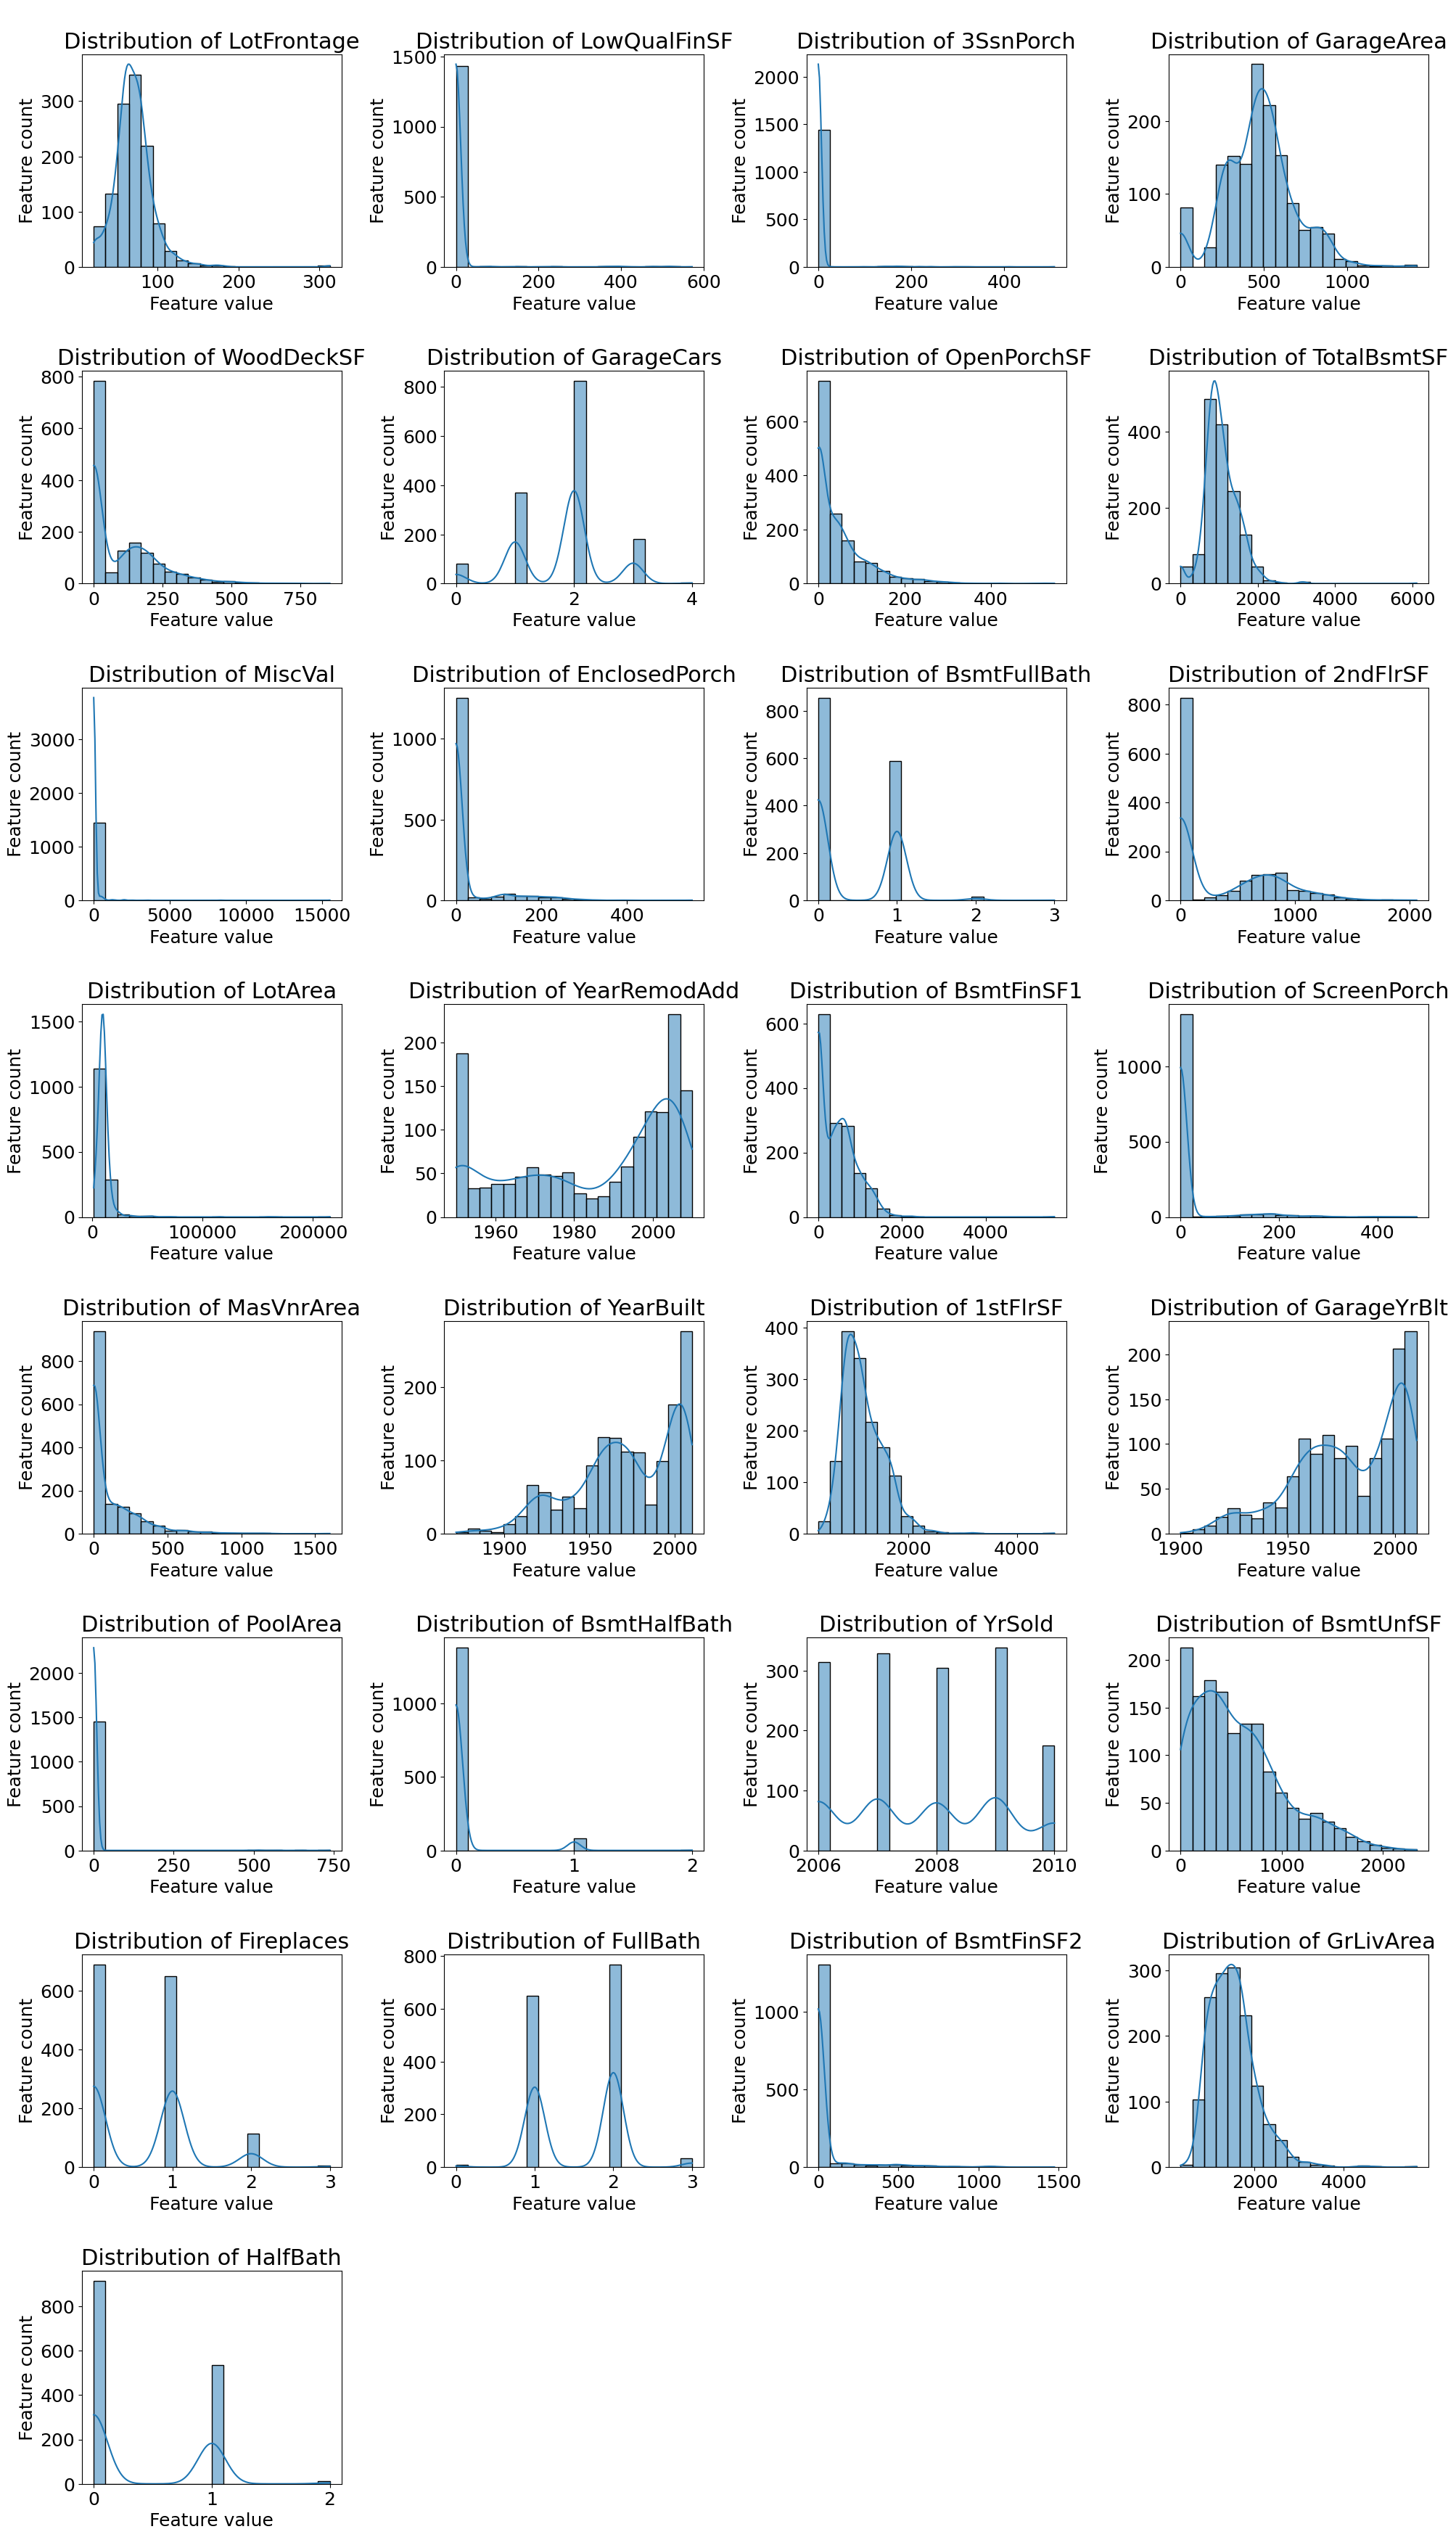

In [ ]:
numeric_features = list(set(numeric_features).difference(set(numeric_category_features)))


# Plotting a scatter chart of features against the target.
fig, axes = plt.subplots(15, 4, figsize=(20, 5 * 13))
axes = axes.flatten()

for i, feature in enumerate(train_raw[numeric_features]):
    sns.histplot(data=train_raw, x=feature, kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'\nDistribution of {feature}', fontsize=22)
    axes[i].set_xlabel('Feature value', fontsize=18)
    axes[i].set_ylabel('Feature count', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=18)  # Major ticks

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

- #### Category feature

In [ ]:
category_features = train_raw.select_dtypes(include=['object']).columns
category_features = list(set(category_features).union(set(numeric_category_features)))
print(f'Number of categorical features: {len(category_features)}')

nominal_features = [
    'RoofStyle', 'GarageType', 'CentralAir', 'Alley', 'SaleType', 'Street', 'MSSubClass',
    'PavedDrive', 'LandContour', 'Heating', 'Neighborhood', 'GarageFinish', 'MasVnrType',
    'Exterior2nd', 'Foundation', 'LotConfig', 'MSZoning','SaleCondition', 'HouseStyle',
    'Condition1', 'Condition2', 'BldgType', 'Exterior1st', 'RoofMatl', 'Utilities',
    'MiscFeature', 'Electrical'
]


print("Number of nominal features: ",len(nominal_features) )

ordinal_features = [
    'KitchenAbvGr', 'BsmtQual', 'BsmtFinType2', 'FireplaceQu', 'Fence', 'BedroomAbvGr',
    'GarageQual', 'ExterCond', 'LotShape', 'KitchenQual', 'GarageCond', 'MoSold',
    'HeatingQC', 'OverallQual', 'TotRmsAbvGrd', 'LandSlope', 'BsmtFinType1', 'PoolQC',
    'Functional', 'BsmtCond', 'OverallCond', 'ExterQual', 'BsmtExposure'
]

print("Number of ordinal features: ", len(ordinal_features) )

Number of categorical features: 50
Number of nominal features:  27
Number of ordinal features:  23


- ### Target distribution

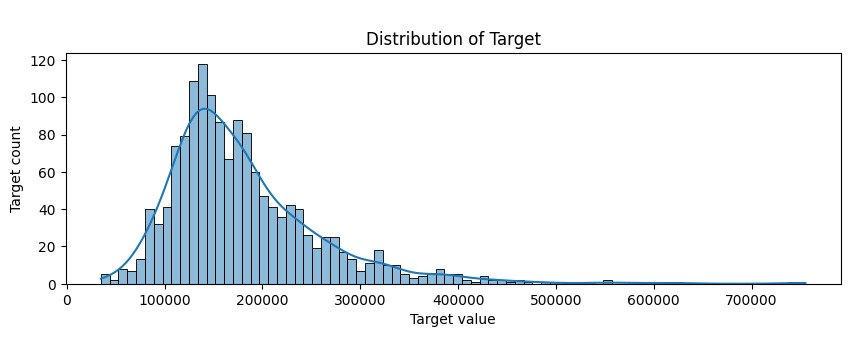

In [ ]:
plt.figure(figsize=(10, 3))
sns.histplot(target, kde=True, bins=80)
plt.title(f'\nDistribution of Target', fontsize=12)
plt.xlabel('Target value', fontsize=10)
plt.ylabel('Target count', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)  # Major ticks
plt.show()

- ### Analysis and hanling a missing data

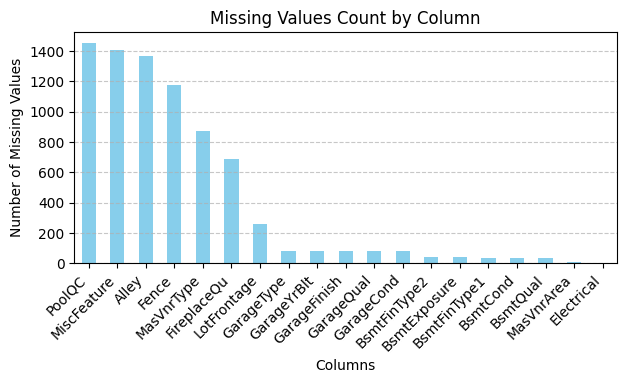


All missing value: 7829


In [ ]:
missing_val_column = train_raw.isnull().sum()
missing_columns = missing_val_column[missing_val_column > 0]

# Plot a missing column by count a vlaue
plt.figure(figsize=(7, 3))
missing_columns.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Missing Values Count by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'\nAll missing value: {train_raw.isna().sum().sum()}')

In [ ]:
custom_fill = {
    "Alley": "No_alley_access",
    "BsmtQual": "No_Basement",
    "BsmtCond": "No_Basement",
    "BsmtExposure": "No_Basement",
    "BsmtFinType1": "No_Basement",
    "BsmtFinType2": "No_Basement",
    "FireplaceQu": "No_Fireplace",
    "GarageType": "No_Garage",
    "GarageFinish": "No_Garage",
    "GarageQual": "No_Garage",
    "GarageCond": "No_Garage",
    "PoolQC": "No_Pool",
    "Fence": "No_Fence",
    "MiscFeature": "None"
}


train_custom_fill = train_raw.copy()
test_custom_fill = test_raw.copy()

for column, value in custom_fill.items():
    train_custom_fill[column] = train_custom_fill[column].fillna(value)
    test_custom_fill[column] = test_custom_fill[column].fillna(value)

print(f'All missing value after custom fill: {train_custom_fill.isna().sum().sum()}')

All missing value after custom fill: 1221


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

def handle_missing_data(train_df, test_df=None, missing_threshold=0.5, category_numerical=[]):

    # Drop columns with high missing percentages and not present in training set
    drop_cols = train_df.columns[train_df.isnull().mean() > missing_threshold]
    train_df = train_df.drop(columns=drop_cols)
    if test_df is not None:
        test_df = test_df.drop(columns=drop_cols, errors='ignore')
        # Keep only the columns present in both datasets
        common_cols = train_df.columns.intersection(test_df.columns)
        train_df = train_df[common_cols]
        test_df = test_df[common_cols]

    # Separate columns by type
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.difference(category_numerical)
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.union(category_numerical)

    # Numerical strategy based on skewness
    skew = train_df[numeric_cols].apply(lambda x: x.skew(skipna=True))
    num_strategy = 'median' if skew.abs().max() > 1 else 'mean'

    # Categorical strategy based on mode frequency
    mode_freq = train_df[categorical_cols].apply(lambda x: x.value_counts(normalize=True).max() if x.notnull().any() else 0)
    cat_strategy = 'most_frequent' if mode_freq.max() > 0.5 else 'constant'
    fill_value = "Not_Specified" if cat_strategy == 'constant' else None

    # Impute missing values
    num_imputer = SimpleImputer(strategy=num_strategy)
    cat_imputer = SimpleImputer(strategy=cat_strategy, fill_value=fill_value)

    train_df[numeric_cols] = num_imputer.fit_transform(train_df[numeric_cols])
    train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])

    if test_df is not None:
        test_df[numeric_cols] = num_imputer.transform(test_df[numeric_cols])
        test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])
        return train_df, test_df

    return train_df

In [ ]:
# Imputing a missing value
train_missing_processed, test_missing_processed = handle_missing_data(
    train_custom_fill,
    test_custom_fill,
    missing_threshold=0.4,
    category_numerical=numeric_category_features
)


print(f"Number of missing value from train set: {train_missing_processed.isna().sum().sum()}")
missing_val_col_train = train_missing_processed.isnull().sum()
missing_col_train = missing_val_col_train[missing_val_col_train > 0]
print(missing_col_train)
print(f'Shape of train set after imputed: {train_missing_processed.shape}')

print(f"\nNumber of missing value from train set: {test_missing_processed.isna().sum().sum()}")
missing_val_col_test = test_missing_processed.isnull().sum()
missing_col_test = missing_val_col_test[missing_val_col_test > 0]
print(missing_col_test)
print(f'Shape of test set after imputed: {test_missing_processed.shape}')

print('\nCheck column if not in train or test of each other.')
print('Columns in train but not in test', set(train_missing_processed.columns) - set(test_missing_processed.columns))
print('Columns in test but not in train', set(test_missing_processed.columns) - set(train_missing_processed.columns))

Number of missing value from train set: 0
Series([], dtype: int64)
Shape of train set after imputed: (1460, 78)

Number of missing value from train set: 0
Series([], dtype: int64)
Shape of test set after imputed: (1459, 78)

Check column if not in train or test of each other.
Columns in train but not in test set()
Columns in test but not in train set()


- ### Data Encoding

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

class DataEncoder:
    def __init__(self, threshold=10, nominal_features=None, ordinal_features=None):
        self.threshold = threshold
        self.label_encoders = {}
        self.onehot_encoders = {}
        self.ordinal_encoders = {}
        self.encoding_types = {}
        self.unique_values = {}
        self.onehot_feature_names = {}
        self.nominal_features = nominal_features or {}
        self.ordinal_features = ordinal_features or {}
        self.category_feature = list(set(self.nominal_features).union(set(ordinal_features)))

    def fit(self, data):
        for col in self.category_feature:
            if col not in data.columns:
                continue

            unique_vals = data[col].unique()
            self.unique_values[col] = unique_vals
            length = len(unique_vals)

            if col in self.ordinal_features:
                self.encoding_types[col] = 'ordinal'
                order = self.ordinal_features[col]
                oe = OrdinalEncoder(categories=[order])
                self.ordinal_encoders[col] = oe.fit(data[[col]])

            elif length == 2 or length > self.threshold:
                # Label encoding
                self.encoding_types[col] = 'label'
                le = LabelEncoder()
                self.label_encoders[col] = le.fit(data[col])

            else:
                # One-hot encoding for smaller categories
                oe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
                self.encoding_types[col] = 'onehot'
                self.onehot_encoders[col] = oe.fit(data[[col]])
                self.onehot_feature_names[col] = oe.get_feature_names_out([col])

    def transform(self, data):
        data_encoded = data.copy()

        for col in self.category_feature:
            if col not in self.encoding_types:
                continue

            if self.encoding_types[col] == 'ordinal':
                # Ordinal encoding with predefined order
                data_encoded[col] = self.ordinal_encoders[col].transform(data[[col]])


            elif self.encoding_types[col] == 'label':
                # Label encoding with handling of unseen values
                unseen = set(data[col]) - set(self.unique_values[col])
                data_encoded[col] = data[col].map(
                    lambda x: self.label_encoders[col].transform([x])[0]
                    if x in self.unique_values[col] else -1
                )

            else:
                # One-hot encoding
                dummies = pd.DataFrame(
                    self.onehot_encoders[col].transform(data[[col]]),
                    index=data.index,
                    columns=self.onehot_feature_names[col]
                )
                data_encoded = data_encoded.drop(col, axis=1)
                data_encoded = pd.concat([data_encoded, dummies], axis=1)

        return data_encoded

In [ ]:
ordinal_str_features = {
    'BsmtQual': ['No_Basement', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtFinType2': ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'FireplaceQu': ['No_Fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['No_Fence', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    'GarageQual': ['No_Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LotShape': ['IR1', 'IR2', 'IR3', 'Reg'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['No_Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'BsmtFinType1': ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'PoolQC': ['No_Pool', 'Fa', 'Gd', 'Ex'],
    'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'BsmtCond': ['No_Basement', 'Po', 'Fa', 'TA', 'Gd'],
    'ExterQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['No_Basement', 'No', 'Mn', 'Av', 'Gd']
}


encoder = DataEncoder(threshold=10,
                      nominal_features=nominal_features,
                      ordinal_features=ordinal_str_features)
encoder.fit(train_missing_processed)

train_encoded = encoder.transform(train_missing_processed)
print(f'Shape of train set after encoded: {train_encoded.shape}\n')

test_encoded = encoder.transform(test_missing_processed)
print(f'Shape of test set after encoded: {test_encoded.shape}')

print('\nCheck column if not in train or test of each other.')
print('Columns in train but not in test', set(train_encoded.columns) - set(test_encoded.columns))
print('Columns in test but not in train', set(test_encoded.columns) - set(train_encoded.columns))

print('Make sure they are all int or float: ', train_encoded.dtypes.unique())
print('Make sure they are all int or float: ', test_encoded.dtypes.unique())

Shape of train set after encoded: (1460, 171)

Shape of test set after encoded: (1459, 171)

Check column if not in train or test of each other.
Columns in train but not in test set()
Columns in test but not in train set()
Make sure they are all int or float:  [dtype('int64') dtype('float64') dtype('O')]
Make sure they are all int or float:  [dtype('int64') dtype('float64') dtype('O')]


<h2 id='feature-selection'>Feature Selection</h2>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from xgboost import XGBRegressor
import shap
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class EnhancedFeatureSelector:
    def __init__(self, X, y, max_features=200, scaler=RobustScaler(),  seed=42):
        self.X = X
        self.y = y
        self.max_features = max_features
        self.scaler = scaler
        self.feature_scores = {}
        self.optimal_features = None
        self.random_state = seed

    def preprocess_data(self):
        """Apply robust scaling or specfict to handle outliers and non-normal distributions"""
        self.X_scaled = pd.DataFrame(
            self.scaler.fit_transform(self.X),
            columns=self.X.columns
        )
        return self.X_scaled

    def lasso_selection(self):
        """Enhanced Lasso with cross-validation and adaptive alpha"""
        lasso = LassoCV(
            cv=5,
            max_iter=2000,
            selection='random',
            n_jobs=-1,
            random_state=self.random_state
        )
        lasso.fit(self.X_scaled, self.y)
        lasso_importances = pd.Series(np.abs(lasso.coef_), index=self.X.columns)
        lasso_importances = lasso_importances[lasso_importances > 0].nlargest(self.max_features)
        self.feature_scores['lasso'] = lasso_importances
        return lasso_importances

    def mutual_information(self):
        """Mutual Information for non-linear relationships"""
        mi_scores = mutual_info_regression(self.X_scaled, self.y)
        mi_series = pd.Series(mi_scores, index=self.X.columns)
        mi_series = mi_series.nlargest(self.max_features)
        self.feature_scores['mutual_info'] = mi_series
        return mi_series

    def spearman_correlation(self):
        """Spearman correlation for non-normal distributions"""
        # Spearman correlation (resistant to outliers)
        correlations = []
        for column in self.X_scaled.columns:
            correlation, _ = stats.spearmanr(self.X_scaled[column], self.y)
            correlations.append(abs(correlation))

        spearman_scores = pd.Series(correlations, index=self.X.columns)
        spearman_scores = spearman_scores.nlargest(self.max_features)
        self.feature_scores['spearman'] = spearman_scores
        return spearman_scores

    def get_optimal_features(self, threshold=0.5):
        """
        Combine all methods and select optimal features using voting
        threshold: minimum proportion of methods that must select a feature
        """
        # Run all feature selection methods
        self.preprocess_data()
        self.lasso_selection()
        self.mutual_information()
        self.spearman_correlation()

        # Create a voting system
        all_features = set()
        feature_votes = {}

        for method_name, scores in self.feature_scores.items():
            features = scores.index.tolist()
            for feature in features:
                if feature not in feature_votes:
                    feature_votes[feature] = 0
                feature_votes[feature] += 1
                all_features.add(feature)

        # Select features that appear in multiple methods
        n_methods = len(self.feature_scores)
        min_votes = max(2, int(n_methods * threshold))  # Feature must appear in at least 2 methods

        selected_features = [
            feature for feature, votes in feature_votes.items()
            if votes >= min_votes
        ]

        # Sort features by average importance across methods
        feature_importance = {}
        for feature in selected_features:
            importance_scores = []
            for scores in self.feature_scores.values():
                if feature in scores:
                    importance_scores.append(scores[feature])
            feature_importance[feature] = np.mean(importance_scores)

        sorted_features = sorted(
            feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )

        self.optimal_features = [feature for feature, _ in sorted_features]
        return self.optimal_features

    def evaluate_feature_set(self, features):
        """Evaluate the performance of selected features using cross-validation"""
        X_selected = self.X_scaled[features]
        model = RandomForestRegressor(n_estimators=100, random_state=self.random_state)
        scores = cross_val_score(
            model, X_selected, self.y,
            cv=5,
            scoring=make_scorer(mean_squared_error)
        )
        return -scores.mean()  # Return negative MSE (higher is better)

    def find_optimal_feature_count(self, min_features=5, step=5):
        """Find the optimal number of features using cross-validation"""
        if self.optimal_features is None:
            self.get_optimal_features()

        best_score = float('-inf')
        best_count = min_features
        print("\nStarting evaluate feature......")

        for n_features in range(min_features, len(self.optimal_features) + 1, step):
            features = self.optimal_features[:n_features]
            score = self.evaluate_feature_set(features)

            if score > best_score:
                best_score = score
                best_count = n_features
            elif n_features > best_count + step * 2:  # Early stopping
                break

        print("......Best feature has been selected")
        return self.optimal_features[:best_count]


    def compare_method_performance(self):
        """Compare performance of different feature selection methods"""
        results = []
        cache = {}  # Cache for storing evaluation results

        # Ensure feature_scores is populated
        if not self.feature_scores:
            self.get_optimal_features()

        # Helper function to evaluate a feature set, with caching
        # to avoid recall evaluate_feature_set() that needs time consumming
        def evaluate_cached(features):
            features_tuple = tuple(features)
            if features_tuple not in cache:
                cache[features_tuple] = -self.evaluate_feature_set(features)
            return cache[features_tuple]

        # Use ThreadPoolExecutor to parallelize evaluations
        with ThreadPoolExecutor() as executor:
            futures = []
            for method_name, selected_features in self.feature_scores.items():
                features = selected_features.index.tolist()[:self.max_features]
                n_features = len(features)
                # Submit evaluation to the executor
                futures.append(
                    executor.submit(
                        lambda m=method_name, f=features, n=n_features: {
                            'method': m,
                            'n_features': n,
                            'score': evaluate_cached(f),
                            'features': f
                        }
                    )
                )

            # Collect results from the futures
            for future in futures:
                results.append(future.result())

        return pd.DataFrame(results)

In [ ]:
y = target.copy()

# Initialize EnhancedFeatureSelector class with paarameter

# Scaler in model should same method in here because even perform well in validation set
# but feature that selected form other scaler then will perform bad in unseen data

start_time = time.time()
print("\nFeature Selecting...")

selector = EnhancedFeatureSelector(train_encoded, y, len(train_encoded.columns),
                                   scaler=StandardScaler(), seed=71

                                  )
performance_comparison = selector.compare_method_performance()

print("\nMethod Performance Comparison:")
print(performance_comparison[['method', 'n_features', 'score']])

# Get automatically selected features
optimal_features = selector.find_optimal_feature_count(
    min_features=5,  # minimum features to consider
    step=5          # step size for feature count optimization
)

training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Access selected features
print(f"\nSelected {len(optimal_features)} features: {optimal_features}")

print(f"\nUsage time is {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss).")


Feature Selecting...

Method Performance Comparison:
        method  n_features         score
0        lasso          46  8.939912e+08
1  mutual_info         171  8.743296e+08
2     spearman         171  8.848281e+08

Starting evaluate feature......
......Best feature has been selected

Selected 80 features: ['GrLivArea', 'OverallQual', 'RoofMatl_ClyTile', 'BsmtFinSF1', 'ExterQual', 'KitchenQual', 'Condition2_PosN', 'SaleType_New', 'MasVnrArea', 'BsmtExposure', 'GarageArea', 'MSSubClass', 'TotalBsmtSF', 'BsmtQual', 'RoofMatl_WdShngl', 'LotArea', 'Fireplaces', 'OverallCond', 'Functional', 'Condition1_Norm', 'GarageFinish_Fin', 'LotConfig_CulDSac', 'GarageCars', 'RoofStyle_Hip', 'Foundation_Slab', 'PoolQC', '1stFlrSF', 'Foundation_PConc', 'LotFrontage', 'BedroomAbvGr', 'SaleCondition_Abnorml', 'MSZoning_RM', 'WoodDeckSF', 'MSZoning_RL', 'YearBuilt', 'KitchenAbvGr', 'LandContour_HLS', 'Heating_OthW', 'GarageType_BuiltIn', 'HeatingQC', 'YearRemodAdd', 'SaleType_COD', 'ScreenPorch', 'SaleC

<h2 id='generalize-data'>Generalize Data</h2>

In [ ]:
X = train_encoded[optimal_features].copy()
# y already definded
X_test = test_encoded[optimal_features].copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1460, 80) y (1460,) X_test (1459, 80)


In [ ]:
from sklearn.model_selection import train_test_split

# If use a cross validation we need not to split a data
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 id='model'>Model and Training</h2>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

- ### Model Architecture

&emsp; The model architecture below are compose with:

&emsp;&emsp; - **Input Layer:** A fully connected layerwith input data and add L2 penalty (`kernel_regularizer=l2(0.01)`) that prevent model are overfitting by penalizing large weights.

&emsp;&emsp; - **Dense Layer:** A fully connected layer where each neuron is connected.

&emsp;&emsp; - **Leaky ReLU Activation:** A variant of the ReLU (Rectified Linear Unit) activation function. The standard ReLU returns 0 for negative values, but Leaky ReLU allows small negative values (by using a small slope alpha=0.1). This prevents "dead neurons" (neurons that stop learning) during training.

&emsp;&emsp; - **Batch Normalization Layer:** This layer normalizes the output of the previous layer. It ensures that the activations remain in a range that is not too high or too low, which can stabilize and accelerate training. It also helps in mitigating the issue of internal covariate shift.

&emsp;&emsp; - **Dropout Layer:** Dropout is a regularization technique to prevent overfitting. During training, it randomly "drops out" of specfic percent of the neurons in this layer. This forces the model to learn more robust features by not relying too heavily on any single neuron.

&emsp;&emsp; - **Output Layer (for Regression):** This final layer outputs a single value, which is the prediction of the model. Since this is a regression problem, there’s no activation function applied, and the output is a continuous numerical value.

<br>
Why I need layers like above?. Because from my experiment the target distribution are skewed distribution,becuase I use dense layer with ReLU as code below. That can lead to a skewed output distribution, especially if many neurons are "dead" (outputting 0). This can hinder the model's ability to learn complex patterns and may not be ideal for certain tasks. While LeakyReLU reduces the sparsity of activations compared to ReLU. Sparsity can lead to skewed distributions, as many neurons are "dead". By allowing some activity for negative inputs, LeakyReLU can create a more balanced distribution of activations.

<pre class='inactive-code'>
<code>
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),  # Normalize the output of the previous layer
    Dropout(0.3),  # Dropout with 30% rate
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
</code>
</pre>

From that reason. In this dataset If you are trying to log transformation with ReLu will make model can not capture a relationship between features and target because with log transformation the target will transform to small value and make model are:
- **ReLU neurons easily "die" during training:** if their inputs become negative, as ReLU outputs zero for all negative inputs. This means those neurons stop learning entirely.
- **Gradient Flow:** With very small values, the gradients flowing backward through the network can become very small, leading to slow learning or the vanishing gradient problem, especially in deeper networks.
- **Loss Function Sensitivity:** When the target values are very small (post-log transformation), the mean squared error loss becomes less sensitive to small differences, which can make it harder for the model to learn fine-grained patterns.

<br>
&emsp; While Many classical machine learning models (like linear regression, support vector machines) often rely on assumptions about the distribution of the data, such as normality.

&emsp; So, transforming a target or feature in ANNs should be a careful and correct match to the activation function or layer in ANNs. And with Leaky ReLU not being too different, we can avoid target transformation in this case and in this case not use an outlier handling technique. But, if we explore or experiment later, maybe significant effects will occur that you should try in the future if you need them.

In [ ]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

# Define the ANNs model
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='huber', metrics=['mae', 'mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,489 (248.00 KB)

 Trainable params: 62,721 (245.00 KB)

 Non-trainable params: 768 (3.00 KB)

- ### Model Training

&emsp; We need training with an early stop that recommends for every dataset size to help us to optimize time and space cost for model training. Because in gradient descent we don't know a true minimum. May be due to local or global minima. So optimizing the finding of a loss process can help us with time and space consumption and optimize a loss from a gradient.

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)  # reduce learning rate

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_validate_scaled, y_validate),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 182507.5000 - mae: 182504.8750 - mse: 39120793600.0000 - val_loss: 177909.4062 - val_mae: 177905.2188 - val_mse: 39284781056.0000 - learning_rate: 0.0100
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 181630.6562 - mae: 181625.6250 - mse: 39004303360.0000 - val_loss: 170762.9062 - val_mae: 170754.4375 - val_mse: 36819992576.0000 - learning_rate: 0.0100
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 172675.7656 - mae: 172665.6875 - mse: 35429515264.0000 - val_loss: 144990.1875 - val_mae: 144975.0781 - val_mse: 28522582016.0000 - learning_rate: 0.0100
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 147258.2188 - mae: 147241.0312 - mse: 27019554816.0000 - val_loss: 81572.9453 - val_mae: 81549.5156 - val_mse: 11626374144.0000 - learning_rate: 0.0100
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95236.3359 - mae: 95210.5391 - mse: 13725393920.0000 - val_loss: 62287.9531 - val_mae: 6225

After training, we need to visualize a model loss that compares to epochs for an interpreter, a two-line training and validation that can be significant to evaluate a model after training before going to the next step of model validation with the validation set and evaluating with the test set.

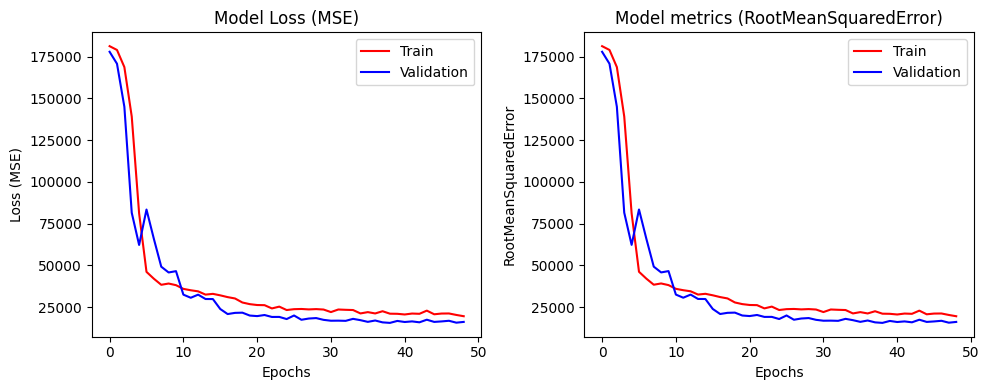

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))

# Plot loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], color='r')
plt.plot(history.history['val_mae'], color='b')
plt.title('Model metrics (RootMeanSquaredError)')
plt.ylabel('RootMeanSquaredError')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

So, the result of the visualization of losses seems to be stable, and the lines of the training and validation sets are already crossing, and the slope of them after the crossing point seems to be small and seem to be in a steady range. Then we can use this model to predict a value for validation and evaluation.

<h2 id='eval'>Model Evaluation</h2>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

- ### Validation set

In [ ]:
# Predict on the validation set
y_pred = model.predict(X_validate_scaled).flatten()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_validate, y_pred))
mae = mean_absolute_error(y_validate, y_pred)
r2 = r2_score(y_validate, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_validate), np.log1p(np.clip(y_pred, a_min=0, a_max=None))))

# Print evaluation results
print("\nValidate set evaluation")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R2): {r2:.2f}")
print(f"Root Mean Square Logarithmic Error (RMSLE): {rmsle:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Validate set evaluation
Root Mean Square Error (RMSE): 25638.22
Mean Absolute Error (MAE): 15521.76
R-Squared (R2): 0.91
Root Mean Square Logarithmic Error (RMSLE): 0.1295


- ### Residual Analysis

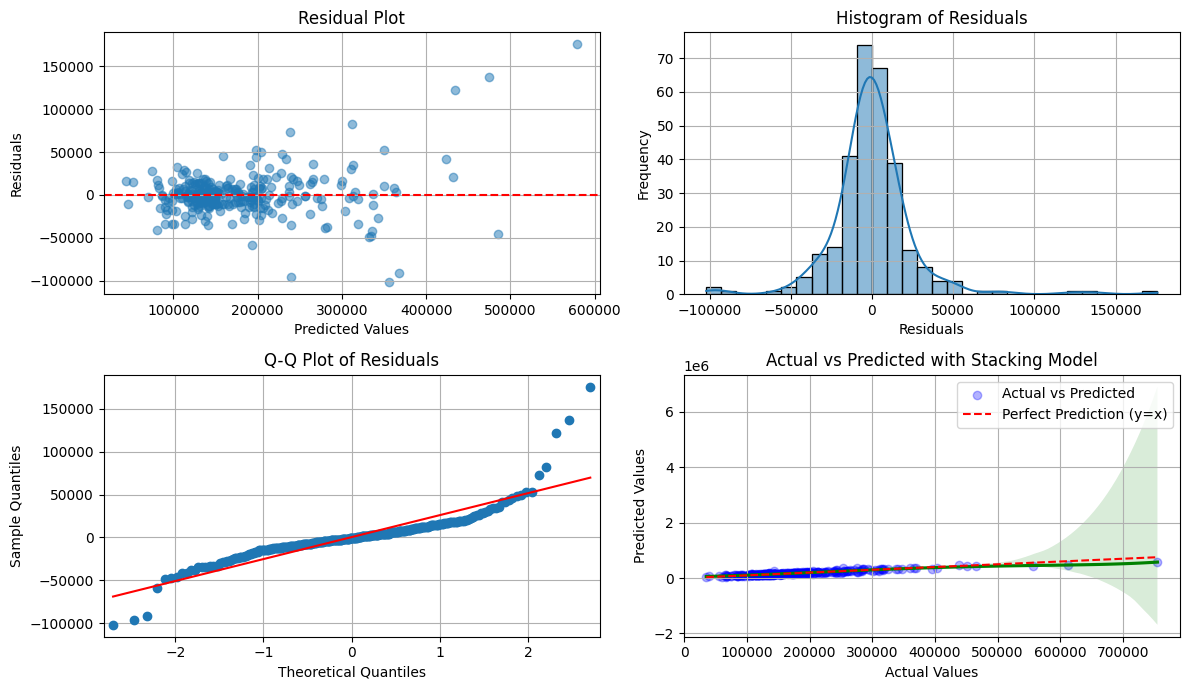


Detected polynomial order: 5
The relationship appears to be non-linear (order 5).


In [ ]:
# Ensure y_validate and X_validate are numpy arrays
if isinstance(y_validate, pd.Series):
    y_validate = y_validate.to_numpy()

# Predict the values
y_predict = model(X_validate_scaled).numpy()  # Use `.numpy()` if using TensorFlow

# Ensure both are flattened arrays
y_validate = y_validate.reshape(-1)
y_predict = y_predict.reshape(-1)

# Check if they are the same size
if len(y_validate) != len(y_predict):
    raise ValueError("y_validate and y_predict must be the same size")

# Calculate residuals
residuals = y_validate - y_predict

# Function to find the best polynomial order for trend line
def find_best_order(x, y, max_order=5):
    best_order = 1
    best_r2 = -np.inf
    for order in range(1, max_order + 1):
        coeffs = np.polyfit(x, y, order)
        poly = np.poly1d(coeffs)
        r2 = 1 - (np.sum((y - poly(x))**2) / np.sum((y - np.mean(y))**2))
        if r2 > best_r2:
            best_r2 = r2
            best_order = order
    return best_order

# Set up the 2x2 grid layout
plt.figure(figsize=(12, 7))

# Residuals vs Predicted Values
plt.subplot(2, 2, 1)
plt.scatter(y_predict, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

# Histogram of Residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()

# Q-Q plot for normality check
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.grid()

# Predicted vs Actual Values Scatter Plot
plt.subplot(2, 2, 4)
plt.scatter(y_validate, y_predict, color='blue', alpha=0.3, label='Actual vs Predicted')

# Find the best polynomial order automatically
best_order = find_best_order(y_validate, y_predict)

# Plot the trend line with detected order
sns.regplot(x=y_validate, y=y_predict,
            scatter=False,
            color='green',
            order=best_order,
            line_kws={"linestyle": "-", "label": f"Model Trend (Order={best_order})"})

# Perfect prediction line
plt.plot([y_validate.min(), y_validate.max()],
         [y_validate.min(), y_validate.max()],
         color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted with Stacking Model")
plt.legend()
plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print the detected relationship type
print(f"\nDetected polynomial order: {best_order}")
if best_order == 1:
    print("The relationship appears to be linear.")
else:
    print(f"The relationship appears to be non-linear (order {best_order}).")

So, from residual analysis, this model is stable with a residual plot that is a random scatter, a histogram of residuals, and a Q-Q plot of residuals that are very close to normality, and actual vs. predicted value seem to be close together on the perfect predicted line (red dot line) that detects relationships between them that are non-linear relationships. That perfected linear relationships should be a straight line with a 45-degree slope only.

- ### Test set ( Unseen data )

In [ ]:
# Ensure X_test is scaled using the same scaler
X_test_scaled = scaler.transform(X_test)

# Predict the SalePrice for the test set
y_pred_test = model.predict(X_test_scaled)

# Create a DataFrame for the output
submission = pd.DataFrame({
    'Id': X_test.index,  # Make sure X_test has an index that corresponds to IDs
    'SalePrice': y_pred_test.flatten()  # Flatten to ensure it's a 1D array for the 'SalePrice' column
})

# Save the predictions to a CSV file
submission.to_csv('submission_ann.csv', index=False)

print("Predictions saved to 'submission_ann.csv'")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predictions saved to 'submission_ann.csv'


<h2 id='closing-words'>Closing words</h2>

  In deep learning, we can design architecture and tuning hyperparameter like learning rate, batch, epoch and etc. And we need to carefully about target transform that should match and optimize to activation fuction or hidden layers condition. That help us to get a plessure model performance. And data quality still importance whatever we use classical machine learning or nueron network (ANNs).
  
  I hope this challenge will be useful for advance regression technique in regression problem using deep learning.